In [5]:
%matplotlib inline
# Grub AI Notebook
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import textblob as tb
from gensim.sklearn_api import W2VTransformer



In [42]:
# Import data
reader = pd.read_json("data/yelp_academic_dataset_review.json", lines=True, chunksize=2000)


In [7]:
#Get dataframe
review_df = None
for chunk in reader:
    review_df = chunk.filter(items=['review_id', 'stars', 'text'])
    break


<AxesSubplot:>

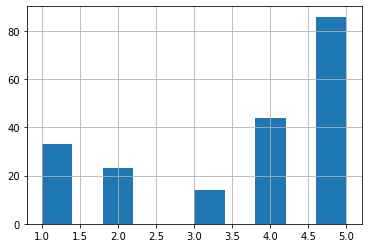

In [82]:
review_df['stars'].hist()

In [14]:
review_df.iloc[[1,5,6]]

,review_id,stars,text
1,UmFMZ8PyXZTY2QcwzsfQYA,1,I am actually horrified this place is still in...
5,L2O_INwlrRuoX05KSjc4eg,5,This is definitely my favorite fast food sub s...
6,ZayJ1zWyWgY9S_TRLT_y9Q,5,"Really good place with simple decor, amazing f..."


In [9]:
#tokenize reviews function
snowball = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [snowball.stem(word) for word in tokenizer.tokenize(text.lower())]

In [10]:
#Tf-idf vectorize reviews function
def vectorize_tfidf(reviews):
    vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, max_features = 1000)
    X = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    return X, words

In [48]:
#Word2Vec vectorize reviews function
def vectorize_wordvec(reviews):
    vectorizer = W2VTransformer(vector_size = 100, min_count = 1, seed = 1)
    Y = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    return Y, words

In [12]:
def glove_model():
    # max number of unique words 
    max_features = 20000
    # max number of words from review to use
    maxlen = 200

    # File path
    embedding_file = 'data/glove.twitter.27B.200d.txt'

    # read in embeddings
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))
    return embeddings_index

In [ ]:
glove_embedding = glove_model()
print(glove_embedding)

In [100]:
def print_clusters(K = 5, num_words = 20):
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
        5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
    pca_num_components = 2
    company_df = review_df
    # company_name = company_df['name'].unique()[0]
    reviews = company_df['text'].values
    # print(len(reviews))
    # print(reviews)
    X, words = vectorize_tfidf(reviews)
    # Y, wordsV = vectorize_wordvec(reviews)
    # Z, wordsG = vectorize_glove(reviews)
    denseX = X.todense()
    # denseY = Y.todense()
    # print(denseX)
    # print(denseX.shape)
    # print(denseY)
    # print(denseY.shape)
    elbow = {2:0,3:0,4:0,5:0}
    for k in range(2,6):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X)
        elbow[k] += kmeans.inertia_
    # for k in elbow.keys():
    #     elbow[k] = elbow[k]/10
    
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(X)

    common_words = kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1]
    print(common_words.shape)
    print(kmeans.labels_)
    plt.figure()
    plt.plot(list(elbow.keys()), list(elbow.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

    reduced_data = PCA(n_components=3).fit_transform(denseX)
    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_data):
         print instance, index, labels[index]
         pca_comp_1, pca_comp_2 = reduced_data[index]
         # color = labels_color_map[kmeans.labels_[index]]
         color = labels_color_map[reviews.iloc[index][1]]
         ax.scatter(pca_comp_1, pca_comp_2, c=color) 
    plt.show()


    mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
    # print(mydict)
    # print(kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1])
    # print(len(words))
    print('Groups of ' + str(num_words) + ' words typically used together in reviews for ' + \
        "all businesses")
    print(mydict[0].tolist())
    # print()
    print([company_df.iloc[mydict[key].tolist()]["stars"].mean() for key in mydict.keys()])

    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

In [101]:
print_clusters("")

(3, 20)
[1 1 0 1 2 0 0 1 1 1 1 1 0 0 2 2 0 1 1 1 2 0 0 0 1 1 0 1 1 1 2 0 2 2 1 0 0
 1 2 1 1 2 2 1 1 1 1 0 2 1 0 1 2 1 1 0 0 0 2 0 1 1 0 0 2 1 0 1 2 1 0 2 1 1
 2 1 2 0 1 1 1 0 0 1 2 1 0 0 2 1 0 0 1 0 0 0 2 0 1 0 0 2 2 1 1 1 1 1 2 1 2
 1 2 0 1 1 1 1 1 0 0 0 0 1 1 1 2 1 2 0 0 2 0 0 0 1 1 1 0 1 0 0 1 1 2 1 1 1
 1 1 1 1 1 2 1 2 1 1 2 0 2 1 1 1 1 0 1 0 0 1 0 2 1 1 2 1 1 1 0 0 0 2 0 1 0
 2 1 1 1 0 2 1 0 0 0 0 1 0 0 1]


TypeError: score() missing 1 required positional argument: 'X'